In [2]:
import pylab as pl
import pandas as pd
import numpy as np
import csv
import json
import sys
import scipy.stats
import urllib2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


##Idea: 
Citibike riders in Brooklyn are younger than riders in Manhattan

## Let's start with a KS test to look at distributions
### Hypotheses:
#####Null hypothesis: 
The distribution of ages of subscribers who start rides in Brooklyn stations is the same as subscribers who start rides in Manhattan stations
#####Alternative hypothesis: 
The distribution of ages of subscribers who start rides in Brooklyn stations is different than subscribers who start rides in Manhattan stations

alpha = 0.05


In [3]:
# Creating csv of station data from Citi Bike

url_stations = 'http://www.citibikenyc.com/stations/json'
limbo = urllib2.urlopen(url_stations)
data = json.load(limbo)
stations = data['stationBeanList']

with open('stations.csv','wb') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerow(['sid','lat','long'])
    for s in stations:
        sid = s['id']
        stationLat = s['latitude']
        stationLong = s['longitude']
        row = [sid,stationLat,stationLong]
        writer.writerow(row)

## We need to wrangle the data first. The CSV of station coordinates was used to join each station id (sid) with the borough it falls within and re-saved as stations.csv with the joined 'boro' field

In [4]:
# Reading in the Citi Bike trip data from Oct 2014
trips = pd.read_csv('data/201410-citibike-tripdata.csv')
trips.head(3)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1027,10/1/2014 00:00:27,10/1/2014 00:17:34,479,9 Ave & W 45 St,40.760193,-73.991255,540,Lexington Ave & E 26 St,40.741473,-73.983209,21376,Subscriber,1977,1
1,534,10/1/2014 00:00:36,10/1/2014 00:09:30,417,Barclay St & Church St,40.712912,-74.010202,417,Barclay St & Church St,40.712912,-74.010202,16086,Subscriber,1974,2
2,416,10/1/2014 00:00:42,10/1/2014 00:07:38,327,Vesey Pl & River Terrace,40.715338,-74.016584,415,Pearl St & Hanover Square,40.704718,-74.009260,16073,Subscriber,1990,1


In [5]:
# Reading in the csv of stations that have been joined with their borough (MH and BK only)
stations = pd.read_csv('data/stations.csv')
stations.head(5)

,X,Y,sid,lat,lon,boro
0,-73.976323,40.683826,83,40.683826,-73.976323,BK
1,-73.978034,40.696089,119,40.696089,-73.978034,BK
2,-73.959282,40.686768,120,40.686768,-73.959282,BK
3,-73.993379,40.692395,143,40.692395,-73.993379,BK
4,-73.980689,40.698399,144,40.698399,-73.980689,BK


In [6]:
# Subsetting the trips data to only look at Subscribers and people with reasonable birth years
trips = trips[(trips['usertype']=='Subscriber')&(trips['birth year']>1925)]
trips['sid'] = trips['start station id']
trips['age'] = 2015-trips['birth year']

# Calculating the median age of riders from trips beginning at each sid
stations_med_age = trips.groupby('sid', as_index=False).agg(median)

type(stations_med_age)
stations_med_age.head(5)

,sid,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,age
0,72,807,72,40.767272,-73.993929,450,40.752554,-73.992390,18003.0,1977,1,38
1,79,561,79,40.719116,-74.006667,347,40.722174,-74.002472,18099.0,1975,1,40
2,82,509,82,40.711174,-74.000165,329,40.714215,-73.997047,18128.0,1979,1,36
3,83,551,83,40.683826,-73.976323,365,40.691960,-73.972652,18019.0,1980,1,35
4,116,511,116,40.741776,-74.001497,458,40.743954,-73.994618,18167.5,1978,1,37


In [7]:
# Merging together the station data - want to add the MH/BK designation)
stations_med_age = pd.merge(stations_med_age, stations, on=['sid'])
stations_med_age.head(5)

,sid,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,age,X,Y,lat,lon,boro
0,72,807,72,40.767272,-73.993929,450,40.752554,-73.992390,18003.0,1977,1,38,-73.993929,40.767272,40.767272,-73.993929,MH
1,79,561,79,40.719116,-74.006667,347,40.722174,-74.002472,18099.0,1975,1,40,-74.006667,40.719116,40.719116,-74.006667,MH
2,82,509,82,40.711174,-74.000165,329,40.714215,-73.997047,18128.0,1979,1,36,-74.000165,40.711174,40.711174,-74.000165,MH
3,83,551,83,40.683826,-73.976323,365,40.691960,-73.972652,18019.0,1980,1,35,-73.976323,40.683826,40.683826,-73.976323,BK
4,116,511,116,40.741776,-74.001497,458,40.743954,-73.994618,18167.5,1978,1,37,-74.001497,40.741776,40.741776,-74.001497,MH


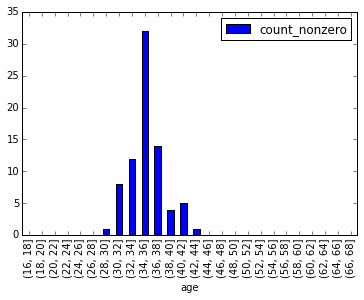

In [8]:
# Subsetting Brooklyn station data and creating histogram of the median ages
BK = stations_med_age[stations_med_age['boro']=='BK']
bins = np.arange(16, 69, 2)
BK.age.groupby(pd.cut(BK.age, bins)).agg([count_nonzero]).plot(kind='bar')

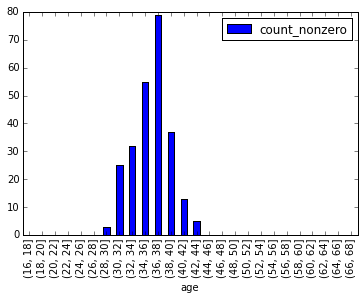

In [9]:
# Subsetting Manhattan station data and creating histogram of the median ages
MH = stations_med_age[stations_med_age['boro']=='MH']
MH.age.groupby(pd.cut(MH.age, bins)).agg([count_nonzero]).plot(kind='bar')

In [10]:
# Creating cummulative distributions for BK and MH
cMH = MH.age.groupby(pd.cut(MH.age, bins)).agg([count_nonzero]).cumsum()
cBK = BK.age.groupby(pd.cut(BK.age, bins)).agg([count_nonzero]).cumsum()

print np.abs(cBK / cBK.max()-cMH / cMH.max())

          count_nonzero
age                    
(16, 18]            NaN
(18, 20]            NaN
(20, 22]            NaN
(22, 24]            NaN
(24, 26]            NaN
(26, 28]            NaN
(28, 30]       0.000939
(30, 32]       0.004433
(32, 34]       0.031763
(34, 36]       0.226464
(36, 38]       0.091013
(38, 40]       0.005633
(40, 42]       0.007093
(42, 44]       0.000000
(44, 46]            NaN
(46, 48]            NaN
(48, 50]            NaN
(50, 52]            NaN
(52, 54]            NaN
(54, 56]            NaN
(56, 58]            NaN
(58, 60]            NaN
(60, 62]            NaN
(62, 64]            NaN
(64, 66]            NaN
(66, 68]            NaN


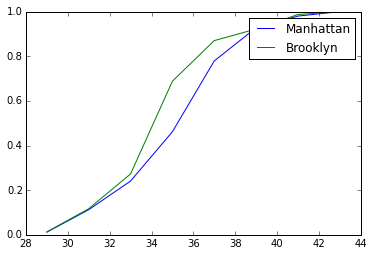

In [11]:
pl.plot(bins[:-1] + 1, cMH / cMH.max(), label = "Manhattan")
pl.plot(bins[:-1] + 1, cBK / cBK.max(), label = "Brooklyn")
pl.legend()

In [12]:
# Runnning a K-S test to compare the samples
ks = scipy.stats.ks_2samp(MH.age, BK.age)
print 'K-S Statistic:', round(ks[0],6)
print 'p value:', round(ks[1],6)

K-S Statistic: 0.226464
p value: 0.003877


## Conclusion:
The p-value of 0.03877 is less than our signficance level alpha = 0.05, therefore we reject the null hypothesis that the distribution of ages for Manhattan and Brooklyn riders look the same.



# Let's do a T-test now!

Null hypothesis:
The average age of subscribers who start rides in Brooklyn stations is greater or the same as subscribers who start rides in Manhattan stations

Alternative hypothesis:
The average of subscribers who start rides in Brooklyn stations is lower than that of subscribers who start rides in Manhattan stations

Assumptions: we assume that the two samples are independently randomly selected samples and that October 2014, which is our chosen month of data, is a representative month. We also assume the age distribution is more or less normal for both populations.

alpha = 0.05

In [123]:
#First let's do some data wrangling, again we're looking at only subscribers and reasonable ages, let's subset trips
trips = trips[(trips['usertype']=='Subscriber')&(trips['birth year']>1925)]
trips['sid'] = trips['start station id']
trips['age'] = 2015-trips['birth year']

#merge station and trips data
mergedtrips = pd.merge(trips, stations, on=['sid'])

mergedtrips.head(3)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,usertype,birth year,gender,sid,age,X,Y,lat,lon,boro
0,1027,10/1/2014 00:00:27,10/1/2014 00:17:34,479,9 Ave & W 45 St,40.760193,-73.991255,540,Lexington Ave & E 26 St,40.741473,...,Subscriber,1977,1,479,38,-73.991255,40.760193,40.760193,-73.991255,MH
1,174,10/1/2014 00:33:34,10/1/2014 00:36:28,479,9 Ave & W 45 St,40.760193,-73.991255,488,W 39 St & 9 Ave,40.756458,...,Subscriber,1990,1,479,25,-73.991255,40.760193,40.760193,-73.991255,MH
2,327,10/1/2014 00:38:14,10/1/2014 00:43:41,479,9 Ave & W 45 St,40.760193,-73.991255,513,W 56 St & 10 Ave,40.768254,...,Subscriber,1956,1,479,59,-73.991255,40.760193,40.760193,-73.991255,MH


In [41]:
boro_merge = mergedtrips.groupby(['boro'], as_index=False).agg(['mean','count'])

In [124]:
#let's take a quick look at the count and average age
age_mean_boro_count = boro_merge['age']
print age_mean_boro_count

           mean   count
boro                   
BK    37.403444   45766
MH    38.629209  707170


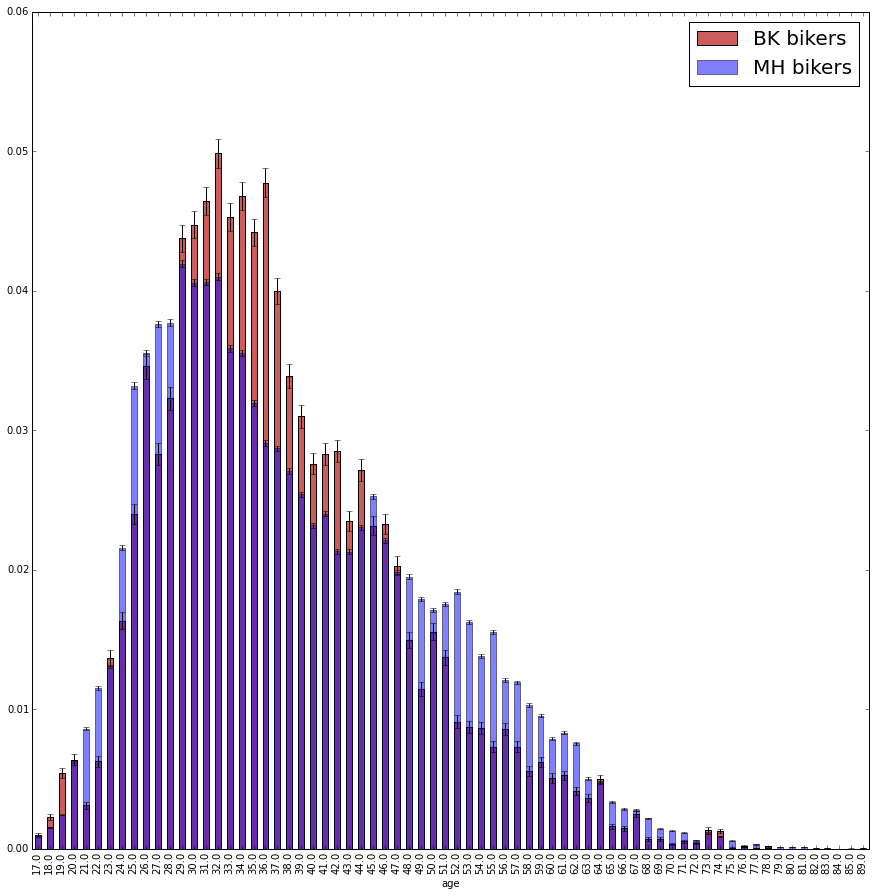

In [125]:
#let's visualize this data.

fig=pl.figure(figsize(15,15))

counts_BK= mergedtrips.boro[mergedtrips.boro=='BK'].groupby([mergedtrips.age]).count()
counts_MH= mergedtrips.boro[mergedtrips.boro=='MH'].groupby([mergedtrips.age]).count()

norm_BK = counts_BK.sum()
error_BK=np.sqrt(counts_BK)
ax = ((counts_BK)/norm_BK).plot(kind="bar",color='IndianRed',  yerr=[((error_BK)/norm_BK,(error_BK)/norm_BK)], label='BK bikers')


norm_MH = counts_MH.sum()
error_MH=np.sqrt(counts_MH)
ax = ((counts_MH)/norm_MH).plot(kind="bar", alpha=0.5, yerr=[((error_MH)/norm_MH,(error_MH)/norm_MH)], label='MH bikers')

pl.legend(['BK bikers','MH bikers'],fontsize=20)

In [126]:
df_BK = mergedtrips[mergedtrips['boro'] == 'BK']['age']
df_MH = mergedtrips[mergedtrips['boro'] == 'MH']['age']

In [128]:
#finally, run a T-Test on these two sample data sets
scipy.stats.ttest_ind(df_BK,df_MH)

(-22.323218963052874, 2.3884394725417008e-110)

#Conclusion:
our t-statistic yields a very small p-value (2.38E-110) which is much less than our chosen alpha of 0.05. Therefore, we reject the null hypothesis. Brooklyn riders are on average younger than Manhattan riders!